In [15]:
%reset
import numpy as np
import pandas as pd
from osgeo import gdal, osr, ogr
from skimage import exposure
from skimage.segmentation import slic
from sklearn.ensemble import RandomForestClassifier
import time
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle

## Based on Tutorial from https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/

# load created data stack
#naip_fn = "D:/cbr/VP2/CodeOutput/output_file_mspec.tif"
#naip_fn = "D:/cbr/VP2/VP2_SoilMapping/CodeOutput/channelFusion_Wetzwil_test.tif"
#naip_fn = "D:/cbr/VP2/VP2_SoilMapping/Processed/Wetzwil_Ortho/verschiedene Stacks/Stack_rgb_dem_ndvi_nir.tif"
naip_fn = "D:/cbr/Brache.tif"
print(naip_fn)
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

nbands = naip_ds.RasterCount
band_data = []

print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
        band = naip_ds.GetRasterBand(i).ReadAsArray()
        band_data.append(band)

band_data = np.dstack(band_data)
print(band_data.shape)



ImportError: DLL load failed while importing minpack2: Das System kann auf die Datei nicht zugreifen.

In [ ]:
# scale image values from 0.0 - 1.0 / 0.0 - 225
#band_data[np.isnan(band_data)] = 0
band_data[np.isnan(band_data)] = -9999.0
img = exposure.rescale_intensity(band_data, in_range= (0.0, 225))

# do segmentation slic (other segmentation types for testing)
seg_start = time.time()
#segments = quickshift(img, ratio=1, convert2lab=False)
#segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
#segments = slic(img, n_segments=1000, compactness= 0.5, start_label = 1, multichannel="TRUE", convert2lab=False)
#segments = slic(img, n_segments=1000, compactness= 1 , start_label = 1, multichannel="TRUE", convert2lab=False)
#segments = slic(img, n_segments=1000, compactness=10, start_label = 1, multichannel="TRUE", convert2lab=False)
segments = slic(img, n_segments=10000, compactness=100, start_label = 1, multichannel="TRUE", convert2lab=False)
#segments = felzenszwalb(img, scale=1000, sigma=0.5, min_size=50, multichannel= True)
print('segments complete', time.time() - seg_start)

# Save segmented Image to File
def CreateGeoTiff(Name, Array, driver, GeoT, Projection, DataType):
    DataSet = driver.Create(Name, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    DataSet.GetRasterBand(1).SetNoDataValue(-9999.0)
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet.FlushCache()
    return Name

#CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed05.tif', segments, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
#CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed1.tif', segments, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
#CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed10.tif', segments, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed100.tif', segments, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

segments complete 183.22606372833252


In [ ]:
# get the ID for every single object, get statistics of features
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

In [ ]:
# load training data
train_fn = "D:/cbr/VP2/VP2_SoilMapping/Shapes/brache_train_klassiert.shp"
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get the unique classes
classes = np.unique(ground_truth)[1:]
print('class values', classes)

# Assign the segments to the respective class.
# Print the number of Segments for each class
segments_per_class = {}
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segment for class", klass, ":", len(segments_of_class))

intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments

assert len(intersection) == 0, "Segments represent multiple classes"

    


min 0 max 4 mean 1.858502709279062e-06
class values [1 2 3 4]
Training segment for class 1 : 16
Training segment for class 2 : 43
Training segment for class 3 : 17
Training segment for class 4 : 4


In [ ]:
train_img = np.copy(segments)
threshold = train_img.max() + 1

for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

training_objects = []
training_labels = []

for klass in classes:
    class_train_object = [v for i,v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] *len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

# Fit the model with the random Forest classifier
classifier = RandomForestClassifier(n_jobs=1)
#classifier = svm.SVC(kernel ="linear")
classifier.fit(training_objects, training_labels)
#importance = classifier.feature_importances_

# Save the model to use it later for other predictions
filename = 'classifier_prediction_m.sav'
pickle.dump(classifier, open(filename, 'wb'))
print('Fitting Random Forest Classifier')
predicted = classifier.predict(objects)
print('Predicting Classification')

clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass

print('Prediction applied to numpy array')

# Create a mask to "cut out" our image from NaN (-9999.0) values
mask = np.sum(img, axis=2)
mask[mask> 0] = 1.0
mask[mask == 0] = -1.0

clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

print('Saving classification to raster')
def CreateGeoTiff(Name, Array, driver, GeoT, Projection, DataType):
    DataSet = driver.Create(Name, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    DataSet.GetRasterBand(1).SetNoDataValue(-9999.0)
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet.FlushCache()
    return Name

CreateGeoTiff('D:/cbr/pred_Brache.tif', clf, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
print('Done')

    

Training objects for class 1 : 16
Training objects for class 2 : 41
Training objects for class 3 : 15
Training objects for class 4 : 4
Fitting Random Forest Classifier
Predicting Classification


KeyboardInterrupt: 

C:\Users\st1154414\.conda\envs\pygdal\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (90933416 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


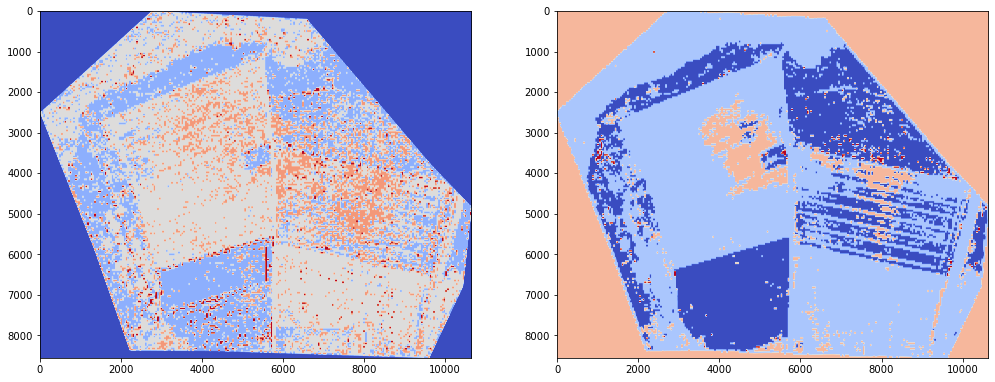

In [ ]:
import matplotlib as mp
import matplotlib.pyplot as plt

# print the classified data for fast checking. 
# For better visualization use QGIS, etc.
img2=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/Wetzwil_Ortho/verschiedene Stacks/Klassifikation_rgb_dem_ndvi_nir_SVM.tif')
img=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/Wetzwil_Ortho/verschiedene Stacks/Klassifikation_rgb_dem_ndvi_nir.tif')


fig, ax = plt.subplots(1, 2, figsize=(17,12))
ax[0].imshow(img2[:, :, 0], cmap=plt.cm.coolwarm)
ax[1].imshow(img[:, :, 0], cmap=plt.cm.coolwarm)